# Importation des Librairies + Datasets

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuration pour afficher tous les graphiques dans le notebook
%matplotlib inline
sns.set_theme(style="whitegrid")

In [32]:
# Chargement de la base de donnée du projet
objects = pd.read_csv('objects.csv', encoding='ISO-8859-1')
funding_rounds = pd.read_csv('funding_rounds.csv', encoding='ISO-8859-1')
investments = pd.read_csv('investments.csv', encoding='ISO-8859-1')
acquisitions = pd.read_csv('acquisitions.csv', encoding='ISO-8859-1')

/tmp/ipython-input-895962019.py:2: DtypeWarning: Columns (3,7,9,10,17,18,21,22,23,25,26,29,30,37) have mixed types. Specify dtype option on import or set low_memory=False.
  objects = pd.read_csv('objects.csv', encoding='ISO-8859-1')


# Analyse des fichiers

In [33]:
# Dictionnaire des DataFrames pour automatiser l'analyse
datasets = {
    "Objects": objects,
    "Funding Rounds": funding_rounds,
    "Investments": investments,
    "Acquisitions": acquisitions
}

for name, df in datasets.items():
    print(f"\n{'='*20} {name} {'='*20}")
    # Analyse de la structure
    print(f"Dimensions : {df.shape}")
    print("\n--- Infos structurelles ---")
    df.info()
    # Détection des valeurs manquantes
    print("\n--- Valeurs manquantes ---")
    print(df.isnull().sum())

    print("\n--- Échantillon (10 lignes) ---")
    display(df.head(10))


==================== Objects ====================
Dimensions : (462651, 40)

--- Infos structurelles ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 462651 entries, 0 to 462650
Data columns (total 40 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   462651 non-null  object 
 1   entity_type          462651 non-null  object 
 2   entity_id            462651 non-null  int64  
 3   parent_id            27715 non-null   object 
 4   name                 462647 non-null  object 
 5   normalized_name      462620 non-null  object 
 6   permalink            462651 non-null  object 
 7   category_code        123186 non-null  object 
 8   status               462651 non-null  object 
 9   founded_at           100441 non-null  object 
 10  closed_at            2809 non-null    object 
 11  domain               174942 non-null  object 
 12  homepage_url         174942 non-null  object 
 13  twitter_usern

,id,entity_type,entity_id,parent_id,name,normalized_name,permalink,category_code,status,founded_at,...,last_funding_at,funding_rounds,funding_total_usd,first_milestone_at,last_milestone_at,milestones,relationships,created_by,created_at,updated_at
0,c:1,Company,1,NaN,Wetpaint,wetpaint,/company/wetpaint,web,operating,2005-10-17,...,2008-05-19,3,39750000.0,2010-09-05,2013-09-18,5,17,initial-importer,2007-05-25 06:51:27,2013-04-13 03:29:00
1,c:10,Company,10,NaN,Flektor,flektor,/company/flektor,games_video,acquired,NaN,...,NaN,0,0.0,NaN,NaN,0,6,initial-importer,2007-05-31 21:11:51,2008-05-23 23:23:14
2,c:100,Company,100,NaN,There,there,/company/there,games_video,acquired,NaN,...,NaN,0,0.0,2003-02-01,2011-09-23,4,12,initial-importer,2007-08-06 23:52:45,2013-11-04 02:09:48
3,c:10000,Company,10000,NaN,MYWEBBO,mywebbo,/company/mywebbo,network_hosting,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 16:51:57,2008-09-06 14:19:18
4,c:10001,Company,10001,NaN,THE Movie Streamer,the movie streamer,/company/the-movie-streamer,games_video,operating,2008-07-26,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 17:10:34,2008-09-06 14:19:18
5,c:10002,Company,10002,NaN,Synergie Media,synergie media,/company/synergie-media,advertising,operating,2007-06-27,...,NaN,0,0.0,NaN,NaN,0,2,NaN,2008-08-24 17:39:10,2008-09-06 14:19:19
6,c:10003,Company,10003,NaN,Green Basti Ecosystems,green basti ecosystems,/company/green-basti-ecosystems,cleantech,operating,2008-08-20,...,NaN,0,0.0,NaN,NaN,0,0,NaN,2008-08-24 19:49:25,2010-04-22 23:48:20
7,c:100042,Company,100042,NaN,HostNine,hostnine,/company/hostnine,NaN,operating,NaN,...,NaN,0,0.0,2011-06-20,2011-06-20,1,1,NaN,2011-09-07 00:53:17,2011-12-20 09:09:53
8,c:10005,Company,10005,NaN,Thomas Publishing,thomas publishing,/company/thomas-publishing,advertising,operating,NaN,...,NaN,0,0.0,1999-06-01,1999-06-01,1,2,NaN,2008-08-24 20:21:21,2009-11-19 17:21:00
9,c:100062,Company,100062,NaN,Vetter Idea Management System,vetter idea management system,/company/vetter-idea-management-system,enterprise,operating,2011-08-01,...,NaN,0,0.0,2011-08-01,2011-08-01,1,2,dmurtagh,2011-09-07 01:04:56,2011-09-24 13:13:18



==================== Funding Rounds ====================
Dimensions : (52928, 23)

--- Infos structurelles ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52928 entries, 0 to 52927
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        52928 non-null  int64  
 1   funding_round_id          52928 non-null  int64  
 2   object_id                 52928 non-null  object 
 3   funded_at                 52680 non-null  object 
 4   funding_round_type        52928 non-null  object 
 5   funding_round_code        52928 non-null  object 
 6   raised_amount_usd         52928 non-null  float64
 7   raised_amount             52928 non-null  float64
 8   raised_currency_code      49862 non-null  object 
 9   pre_money_valuation_usd   52928 non-null  float64
 10  pre_money_valuation       52928 non-null  float64
 11  pre_money_currency_code   26883 non-null  object 
 12  post

,id,funding_round_id,object_id,funded_at,funding_round_type,funding_round_code,raised_amount_usd,raised_amount,raised_currency_code,pre_money_valuation_usd,...,post_money_valuation,post_money_currency_code,participants,is_first_round,is_last_round,source_url,source_description,created_by,created_at,updated_at
0,1,1,c:4,2006-12-01,series-b,b,8500000.0,8500000.0,USD,0.0,...,0.0,NaN,2,0,0,http://www.marketingvox.com/archives/2006/12/2...,NaN,initial-importer,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,2,c:5,2004-09-01,angel,angel,500000.0,500000.0,USD,0.0,...,0.0,USD,2,0,1,NaN,NaN,initial-importer,2007-05-27 06:08:18,2013-06-28 20:07:23
2,3,3,c:5,2005-05-01,series-a,a,12700000.0,12700000.0,USD,115000000.0,...,0.0,USD,3,0,0,http://www.techcrunch.com/2007/11/02/jim-breye...,Jim Breyer: Extra $500 Million Round For Faceb...,initial-importer,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,2006-04-01,series-b,b,27500000.0,27500000.0,USD,525000000.0,...,0.0,USD,4,0,0,http://www.facebook.com/press/info.php?factsheet,Facebook Funding,initial-importer,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,5,c:7299,2006-05-01,series-b,b,10500000.0,10500000.0,USD,0.0,...,0.0,NaN,2,0,0,http://www.techcrunch.com/2006/05/14/photobuck...,PhotoBucket Closes $10.5M From Trinity Ventures,initial-importer,2007-05-29 11:05:59,2008-04-16 17:09:12
5,6,6,c:9,2007-01-01,series-a,a,1500000.0,1500000.0,USD,8500000.0,...,10000000.0,USD,1,0,1,NaN,NaN,initial-importer,2007-05-31 20:19:28,2009-01-19 18:29:39
6,7,7,c:9,2007-03-01,series-b,b,10000000.0,10000000.0,USD,100000000.0,...,110000000.0,USD,1,0,0,http://www.techcrunch.com/2007/03/05/100-milli...,100 Million Valuation for Geni,initial-importer,2007-05-31 20:35:03,2009-01-19 18:29:39
7,8,8,c:13,2005-12-01,series-a,seed,1500000.0,1500000.0,USD,0.0,...,0.0,NaN,4,0,0,http://www.techcrunch.com/2006/11/14/stumbleup...,StumbleUpon May Be For Sale: 50M,initial-importer,2007-06-01 19:14:34,2011-03-10 02:38:18
8,9,9,c:14,2007-05-01,series-a,a,6300000.0,6300000.0,USD,0.0,...,0.0,NaN,2,0,1,http://www.techcrunch.com/2007/05/31/gizmoz-la...,NaN,initial-importer,2007-06-01 20:09:47,2008-03-17 04:11:44
9,10,10,c:15,2006-06-01,angel,seed,12000.0,12000.0,USD,0.0,...,0.0,NaN,1,0,1,http://www.techcrunch.com/2007/03/06/scribd-yo...,"Scribd ""YouTube for DocumentsÂ"" Gets $300K",initial-importer,2007-06-02 07:36:21,2012-08-13 23:30:48



==================== Investments ====================
Dimensions : (80902, 6)

--- Infos structurelles ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80902 entries, 0 to 80901
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   id                  80902 non-null  int64 
 1   funding_round_id    80902 non-null  int64 
 2   funded_object_id    80902 non-null  object
 3   investor_object_id  80902 non-null  object
 4   created_at          80902 non-null  object
 5   updated_at          80902 non-null  object
dtypes: int64(2), object(4)
memory usage: 3.7+ MB

--- Valeurs manquantes ---
id                    0
funding_round_id      0
funded_object_id      0
investor_object_id    0
created_at            0
updated_at            0
dtype: int64

--- Échantillon (10 lignes) ---


,id,funding_round_id,funded_object_id,investor_object_id,created_at,updated_at
0,1,1,c:4,f:1,2007-07-04 04:52:57,2008-02-27 23:14:29
1,2,1,c:4,f:2,2007-07-04 04:52:57,2008-02-27 23:14:29
2,3,3,c:5,f:4,2007-05-27 06:09:10,2013-06-28 20:07:23
3,4,4,c:5,f:1,2007-05-27 06:09:36,2013-06-28 20:07:24
4,5,4,c:5,f:5,2007-05-27 06:09:36,2013-06-28 20:07:24
5,6,4,c:5,f:6,2007-05-27 06:09:36,2013-06-28 20:07:24
6,7,4,c:5,f:3181,2007-05-27 06:09:36,2013-06-28 20:07:24
7,8,5,c:7299,f:3,2007-05-29 11:05:59,2008-04-16 17:09:12
8,9,6,c:9,f:6,2007-05-31 20:19:28,2009-01-19 18:29:39
9,10,7,c:9,f:7,2007-05-31 20:35:03,2009-01-19 18:29:39



==================== Acquisitions ====================
Dimensions : (9562, 12)

--- Infos structurelles ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9562 entries, 0 to 9561
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   9562 non-null   int64  
 1   acquisition_id       9562 non-null   int64  
 2   acquiring_object_id  9562 non-null   object 
 3   acquired_object_id   9561 non-null   object 
 4   term_code            1906 non-null   object 
 5   price_amount         9562 non-null   float64
 6   price_currency_code  9558 non-null   object 
 7   acquired_at          9533 non-null   object 
 8   source_url           8566 non-null   object 
 9   source_description   8590 non-null   object 
 10  created_at           9562 non-null   object 
 11  updated_at           9562 non-null   object 
dtypes: float64(1), int64(2), object(9)
memory usage: 896.6+ KB

--- Valeurs manquan

,id,acquisition_id,acquiring_object_id,acquired_object_id,term_code,price_amount,price_currency_code,acquired_at,source_url,source_description,created_at,updated_at
0,1,1,c:11,c:10,NaN,2.000000e+07,USD,2007-05-30,http://venturebeat.com/2007/05/30/fox-interact...,Fox Interactive confirms purchase of Photobuck...,2007-05-31 22:19:54,2008-05-21 19:23:44
1,2,7,c:59,c:72,cash,6.000000e+07,USD,2007-07-01,http://www.techcrunch.com/2007/07/02/deal-is-c...,Deal is Confirmed: Google Acquired GrandCentral,2007-07-03 08:14:50,2011-05-06 21:51:05
2,3,8,c:24,c:132,cash,2.800000e+08,USD,2007-05-01,http://www.techcrunch.com/2007/05/30/cbs-acqui...,CBS Acquires EuropeÃ¢ÂÂs Last.fm for $280 mi...,2007-07-12 04:19:24,2008-05-19 04:48:50
3,4,9,c:59,c:155,cash,1.000000e+08,USD,2007-06-01,http://techcrunch.com/2007/05/23/100-million-p...,$100 Million Payday For Feedburner Â This Dea...,2007-07-13 09:52:59,2012-06-05 03:22:17
4,5,10,c:212,c:215,cash,2.500000e+07,USD,2007-07-01,http://blog.seattlepi.nwsource.com/venture/arc...,seatlepi.com,2007-07-20 05:29:07,2008-02-25 00:23:47
5,6,11,c:227,c:228,NaN,7.140000e+06,USD,2003-08-05,http://www.businessweek.com/magazine/content/0...,E-Society: My World Is Cyworld,2007-07-20 09:58:29,2009-04-07 22:02:37
6,7,12,c:5,c:230,cash,0.000000e+00,USD,2007-07-01,http://www.techcrunch.com/2007/07/19/breaking-...,NaN,2007-07-26 07:36:07,2009-08-10 19:37:37
7,8,14,c:318,c:314,cash,0.000000e+00,USD,2006-10-01,http://techcrunch.com/2006/10/31/breaking-news...,Breaking News: CondÃ© Nast/Wired Acquires Reddit,2007-07-31 07:38:36,2012-01-16 03:04:04
8,9,15,c:20,c:333,stock,1.500000e+09,USD,2002-07-08,http://news.cnet.com/2100-1017-941964.html,eBay picks up PayPal for $1.5 billion,2007-08-01 09:58:26,2008-10-06 19:04:29
9,10,16,c:342,c:341,cash,3.500000e+08,USD,2007-08-01,http://online.wsj.com/article/SB11859976880408...,Disney Buys Kids' Social-Network Site,2007-08-02 09:12:27,2009-08-31 17:43:37


## 1. Analyse Objects.csv

- Plus de 73% de manquants pour category_code et 78% pour founded_at

- De nombreuses colonnes comme parent_id, logo_url ou domain n'ont aucune valeur prédictive pour le succès d'une startup

## 2. Analyse funding_rounds.csv

- Contrairement au fichier Objects, la colonne cruciale raised_amount_usd ne présente aucune valeur manquante (52 928 non-null). C'est une excellente nouvelle pour la précision de notre futur modèle supervisé.

- Les colonnes de valorisation (pre_money_valuation et post_money_currency_code) sont vides à près de 50%. Elles seront donc écartées pour éviter de réduire drastiquement la taille du dataset final.

- La date de levée (funded_at) est quasi complète (seulement 248 manquants sur 53k lignes), ce qui permettra de calculer la vélocité de financement.

## 3. Analyse investments.csv

- Ce fichier est techniquement "parfait" avec 0 valeur manquante sur les 80 902 lignes.

- Il contient les clés de liaison fondamentales : funded_object_id (la startup) et investor_object_id (l'investisseur)

- Il s'agit d'une table de faits qui répertorie chaque participation d'un investisseur à un round de financement.

## 4. Analyse acquisitions.csv

- Ce fichier identifie les cibles (acquired_object_id) et les acheteurs (acquiring_object_id).

- La structure est relativement saine pour les colonnes d'identification. Cependant, les colonnes financières (price_amount) et contractuelles (term_code) sont très lacunaires ou comportent des valeurs à zéro.

- Le term_code est manquant à 80 % (7 656 vides). Comme pour les fichiers précédents, nous allons écarter les colonnes "bruit" (URLs, descriptions) pour optimiser la mémoire.


# Phase de Nettoyage

## 1.Nettoyage objects.csv

In [34]:
# On ne garde que les entreprises (Company)
df_objects_clean = objects[objects['entity_type'] == 'Company'].copy()

# On supprime les colonnes inutiles ou trop vides pour optimiser la mémoire
cols_to_keep = [
    'id', 'name', 'category_code', 'status', 'founded_at',
    'country_code', 'funding_total_usd', 'funding_rounds', 'relationships'
]
df_objects_clean = df_objects_clean[cols_to_keep]

# On supprime les lignes sans secteur, pays ou date (trop critiques pour être imputées)
df_objects_clean.dropna(subset=['category_code', 'founded_at', 'country_code'], inplace=True)

# Conversion de la date de fondation en objet datetime
df_objects_clean['founded_at'] = pd.to_datetime(df_objects_clean['founded_at'], errors='coerce')

# Transformation du statut en binaire : 1 si succès (acquired/ipo), 0 sinon
df_objects_clean['is_success'] = df_objects_clean['status'].apply(lambda x: 1 if x in ['acquired', 'ipo'] else 0)

print(f"Volume après nettoyage : {df_objects_clean.shape}")

Volume après nettoyage : (64099, 10)


- Un modèle ne peut être meilleur que la donnée fournie. En supprimant les lignes incomplètes sur les secteurs et les dates, on assure des résultats généralisables

- Les algorithmes de ML ne traitent pas les dates brutes ; la conversion est un prérequis obligatoire pour l'ingénierie de variables futures.

- Cette approche réduit le volume global mais augmente la densité d'information, ce qui est le plus important pour notre scoring

## 2. Nettoyage funding_rounds.csv

In [35]:

# Sélection des colonnes utiles (Réduction de la dette technique)
cols_finance = ['object_id', 'funding_round_type', 'raised_amount_usd', 'funded_at']
df_rounds_clean = funding_rounds[cols_finance].copy()

# Suppression des rares lignes sans date
df_rounds_clean.dropna(subset=['funded_at'], inplace=True)

# Conversion au format Datetime (
df_rounds_clean['funded_at'] = pd.to_datetime(df_rounds_clean['funded_at'], errors='coerce')

# Aperçu statistique des montants (Détection d'outliers)
print("Statistiques des levées (USD) :")
print(df_rounds_clean['raised_amount_usd'].describe())

print(f"\nVolume final de df_rounds_clean : {df_rounds_clean.shape}")

Statistiques des levées (USD) :
count    5.268000e+04
mean     7.967552e+06
std      4.225020e+07
min      0.000000e+00
25%      2.500000e+05
50%      1.600000e+06
75%      6.800000e+06
max      3.835050e+09
Name: raised_amount_usd, dtype: float64

Volume final de df_rounds_clean : (52680, 4)


- On ne conserve que la "moelle épinière" financière : l'ID de la startup, le type de round, le montant en USD et la date.

- Conversion de funded_at en format datetime pour permettre les calculs chronologiques.

- S'assurer que les montants sont bien traités comme des numériques continus pour le futur scaling.

## 3. Nettoyage investments.csv

In [36]:

# Sélection des colonnes relationnelles
df_investments_clean = investments[['funding_round_id', 'funded_object_id', 'investor_object_id']].copy()

# Détection et suppression des doublons
duplicate_count = df_investments_clean.duplicated().sum()
print(f"Nombre de doublons détectés : {duplicate_count}")
df_investments_clean.drop_duplicates(inplace=True)

# Vérification de la structure
print(f"Volume final de df_investments_clean : {df_investments_clean.shape}")
display(df_investments_clean.head(10))

Nombre de doublons détectés : 102
Volume final de df_investments_clean : (80800, 3)


,funding_round_id,funded_object_id,investor_object_id
0,1,c:4,f:1
1,1,c:4,f:2
2,3,c:5,f:4
3,4,c:5,f:1
4,4,c:5,f:5
5,4,c:5,f:6
6,4,c:5,f:3181
7,5,c:7299,f:3
8,6,c:9,f:6
9,7,c:9,f:7


- Suppression des doublons pour éviter de surestimer l'influence d'un investisseur dans votre futur calcul de prestige

- Suppression des colonnes temporelles système (created_at, updated_at) qui ne servent pas à la modélisation métier.

-On ne garde que le triplet funding_round_id, funded_object_id et investor_object_id pour la préparation de graphs

## 4. Nettoyage acquisition.csv

In [37]:
# Sélection des colonnes essentielles pour le marquage du succès
df_acq_clean = acquisitions[['acquired_object_id', 'acquired_at']].copy()

# Suppression de la seule ligne manquante sur l'ID de la cible
df_acq_clean.dropna(subset=['acquired_object_id'], inplace=True)

# Conversion au format Datetime
df_acq_clean['acquired_at'] = pd.to_datetime(df_acq_clean['acquired_at'], errors='coerce')

# Suppression des doublons (Une startup ne peut être acquise qu'une fois)
df_acq_clean.drop_duplicates(subset=['acquired_object_id'], inplace=True)

print(f"Volume final de df_acq_clean : {df_acq_clean.shape}")

Volume final de df_acq_clean : (9411, 2)


- Nous allons utiliser ce fichier uniquement pour créer un dictionnaire de succès. Si une startup apparaît ici, elle est marquée comme is_success = 1 dans notre dataset final.

- Suppression des colonnes inutiles (source_url, source_description, created_at).

- Conversion de acquired_at en datetime.

# Données prêtes:

- df_objects_clean : L'identité des startups.

- df_rounds_clean : L'historique des financements.

- df_investments_clean : Le réseau des investisseurs.

- df_acq_clean : Le registre des succès.


Nous allons maintenant passer à à la fusion de nos informations nettoyéesdans un DataFrame nommé df_final. Celui ci nous servira à l'analyse Eploratoire (EDA) et à l'entrainement de nos modèles.

/tmp/ipython-input-863145943.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')


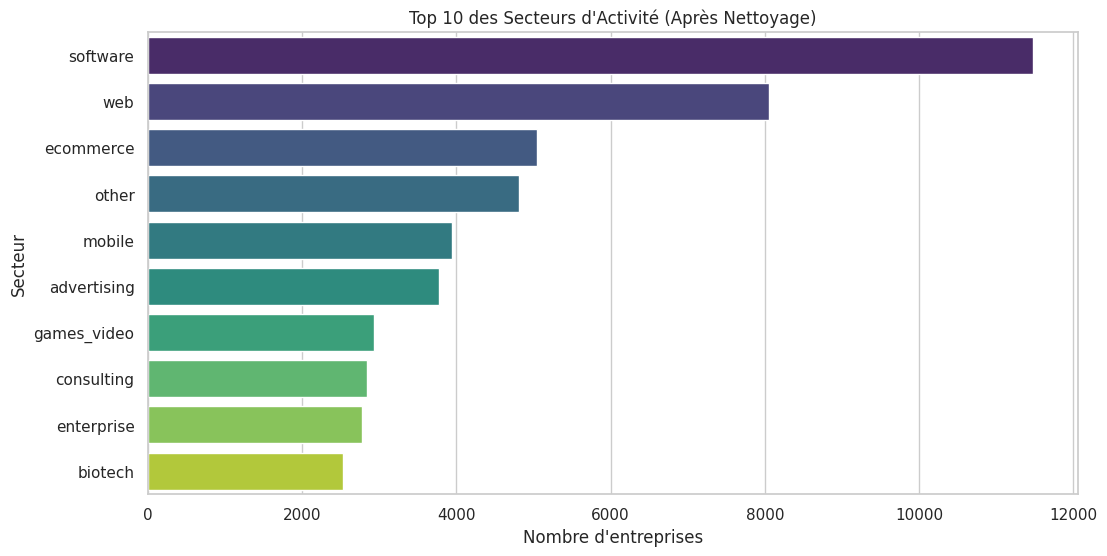

In [38]:
# 1. Distribution des Top 10 Secteurs (df_objects_clean)
plt.figure(figsize=(12, 6))
top_categories = df_objects_clean['category_code'].value_counts().head(10)
sns.barplot(x=top_categories.values, y=top_categories.index, palette='viridis')
plt.title('Top 10 des Secteurs d\'Activité (Après Nettoyage)')
plt.xlabel('Nombre d\'entreprises')
plt.ylabel('Secteur')
plt.show()

## Remarque sur le graphique :

- Le graphique montre une domination nette des secteurs liés au Software, au Web et à l'Entreprise.

- Malgré un gros nettoyage  ayant réduit le volume à environ 64 000 entreprises, la distribution reste représentative de l'économie numérique.

- Cette forte concentration suggère que le secteur d'activité sera une variable catégorielle déterminante (Feature) pour nos modèles de Machine Learning.


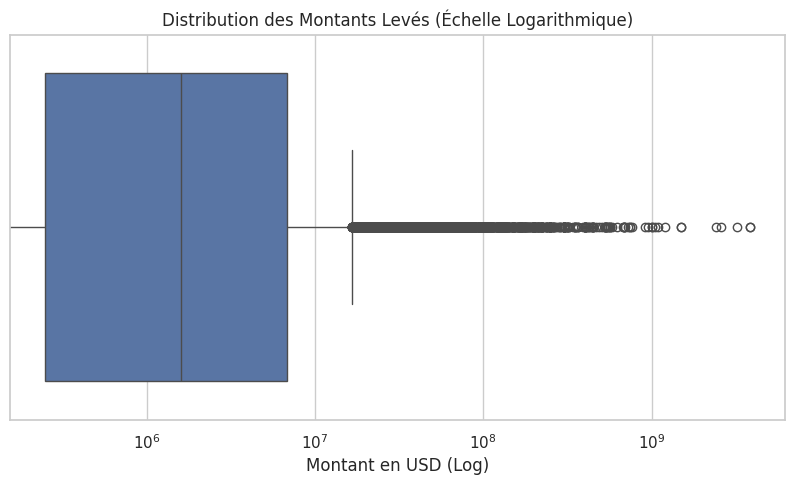

In [39]:
# 2. Visualisation des Outliers Financiers (Fichier Funding Rounds)
plt.figure(figsize=(10, 5))
sns.boxplot(x=df_rounds_clean['raised_amount_usd'])
plt.xscale('log') # Échelle log car l'écart entre 0 et 3.8 milliards est trop grand
plt.title('Distribution des Montants Levés (Échelle Logarithmique)')
plt.xlabel('Montant en USD (Log)')
plt.show()

## Remarque sur le graphique :

- L'utilisation d'une échelle logarithmique est indispensable pour visualiser la donnée tant les écarts sont massifs (de quelques milliers à 3,8 milliards USD).

- Le boxplot révèle une multitude d'outliers (valeurs aberrantes) situés bien au-delà de la moustache supérieure. Cela confirme l'asymétrie (skewness) de la donnée financière.

- Ce graphique justifie mathématiquement notre choix d'utiliser la médiane ($\approx 1,6 \text{M USD}$) plutôt que la moyenne ($\approx 7,9 \text{M USD}$) pour l'imputation, car la moyenne est artificiellement tirée vers le haut par les "méga-levées".

/tmp/ipython-input-3282824468.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_rounds_clean, y='funding_round_type', order=round_types.index, palette='magma')


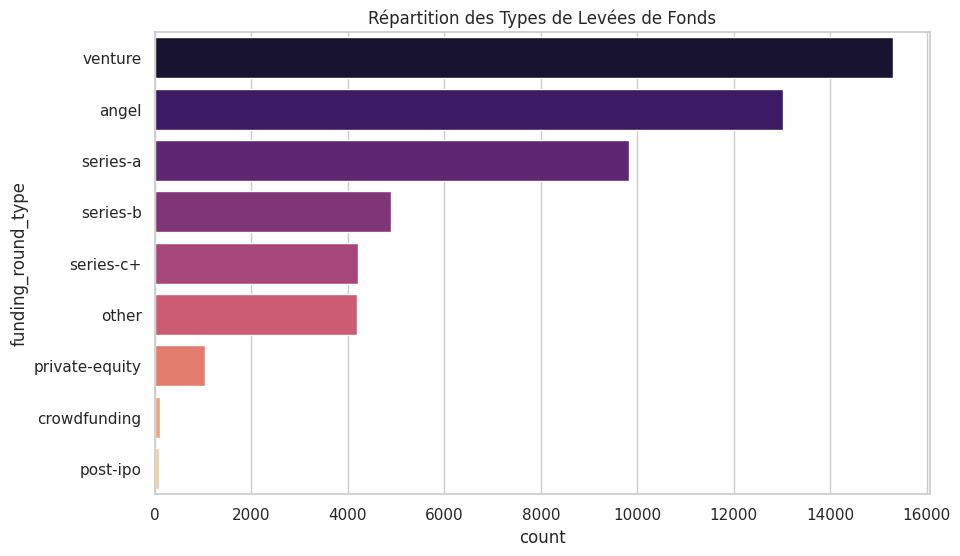

In [40]:
# 3. Répartition des types de financement
plt.figure(figsize=(10, 6))
round_types = df_rounds_clean['funding_round_type'].value_counts()
sns.countplot(data=df_rounds_clean, y='funding_round_type', order=round_types.index, palette='magma')
plt.title('Répartition des Types de Levées de Fonds')
plt.show()

## Remarque sur le graphique :  

- Les rounds de type Seed et Series-A sont les plus fréquents, suivis par les investissements "Angel"

- Le dataset capture majoritairement des startups en phase de démarrage. Pour notre modèle, la transition vers des Series-B ou C sera un signal fort de survie et de succès potentiel.

- Cette distribution nous incite à traiter le funding_round_type comme une variable ordinale lors du préprocessing.

## Fusion des données nettoyées :

In [41]:
# Agrégation des levées de fonds par startup
# On calcule le montant total levé et le nombre de rounds pour chaque entreprise
df_rounds_agg = df_rounds_clean.groupby('object_id').agg({
    'raised_amount_usd': 'sum',
    'funding_round_type': 'count'
}).rename(columns={
    'raised_amount_usd': 'total_funding_usd',
    'funding_round_type': 'funding_rounds_count'
}).reset_index()

# Fusion de la table Objects avec les données financières
# Utilisation d'un 'left join' pour garder toutes les boîtes nettoyées
df_final = pd.merge(df_objects_clean, df_rounds_agg, left_on='id', right_on='object_id', how='left')

# Marquage des succès via la table Acquisitions
# On vérifie si l'ID de la startup est présent dans la liste des acquisitions
df_final = pd.merge(df_final, df_acq_clean[['acquired_object_id', 'acquired_at']],
                    left_on='id', right_on='acquired_object_id', how='left')

# Finalisation de la variable cible 'is_success'
# Une startup a réussi si elle est déjà marquée 'acquired'/'ipo' OU si elle est dans df_acq
df_final['is_success'] = df_final['is_success'].fillna(0)
df_final.loc[df_final['acquired_at'].notnull(), 'is_success'] = 1

# Nettoyage final post-fusion
df_final['total_funding_usd'] = df_final['total_funding_usd'].fillna(0)
df_final['funding_rounds_count'] = df_final['funding_rounds_count'].fillna(0)

# Suppression des colonnes techniques de jointure devenues inutiles
df_final.drop(columns=['object_id', 'acquired_object_id', 'acquired_at'], inplace=True)

print(f"Volume du dataset consolidé : {df_final.shape}")
display(df_final.head())

Volume du dataset consolidé : (64099, 12)


,id,name,category_code,status,founded_at,country_code,funding_total_usd,funding_rounds,relationships,is_success,total_funding_usd,funding_rounds_count
0,c:1,Wetpaint,web,operating,2005-10-17,USA,39750000.0,3,17,0,39750000.0,3.0
1,c:10002,Synergie Media,advertising,operating,2007-06-27,MAR,0.0,0,2,0,0.0,0.0
2,c:10003,Green Basti Ecosystems,cleantech,operating,2008-08-20,IND,0.0,0,0,0,0.0,0.0
3,c:10009,dimension5 labs,advertising,operating,2008-08-01,USA,0.0,0,2,0,0.0,0.0
4,c:1001,FriendFeed,web,acquired,2007-10-01,USA,5000000.0,1,14,1,5000000.0,1.0


## Rapport sur le Merge :

- objects.csv est devenu Le Squelette : Il fournit la structure de base (ID, Nom, Secteur, Pays, Date de fondation). C'est la table "maître" qui porte l'identité de chaque startup.


- funding_rounds.csv sert de carburant : Il a été "compressé" via une agrégation. Au lieu d'avoir plusieurs lignes par startup pour chaque levée, on a désormais deux indicateurs uniques par entreprise : total_funding_usd (somme de l'argent reçu) et funding_rounds_count (nombre de fois où elle a levé des fonds).



- acquisitions.csv sert de dictionnaire de vérification. Si l'ID d'une startup était présent dans ce fichier, nous avons forcé sa variable is_success à 1, même si son statut initial dans objects n'était pas à jour.

- Enfin investments.csv sera utilisé pour la partie Modèle non-supervisé pour calcluer l'influence des investisseur sans polluer la structure de la table de classification supervisée.

Les données de financement ont été transformées par une opération de groupby, permettant de convertir un historique transactionnel en variables statistiques clés : le montant total levé et le nombre de rounds de financement.

Étiquetage de la cible : La variable cible is_success a été binarisée (0 ou 1) en croisant le statut initial avec le registre des acquisitions, garantissant une vérité terrain fiable pour l'entraînement des futurs modèles.

- Le dataset final comprend 64 099 observations et 12 variables prédictives.

- Cohérence métier : L'analyse des premières lignes (échantillon) confirme la robustesse de la fusion : les startups à succès (ex: FriendFeed) sont correctement identifiées avec leurs indicateurs financiers et relationnels respectifs.

- Prêt pour la modélisation : Cette table unique réunit désormais les dimensions temporelles, géographiques, sectorielles et financières nécessaires pour répondre à notre problématique de prédiction.

# Modèle non-supervisé

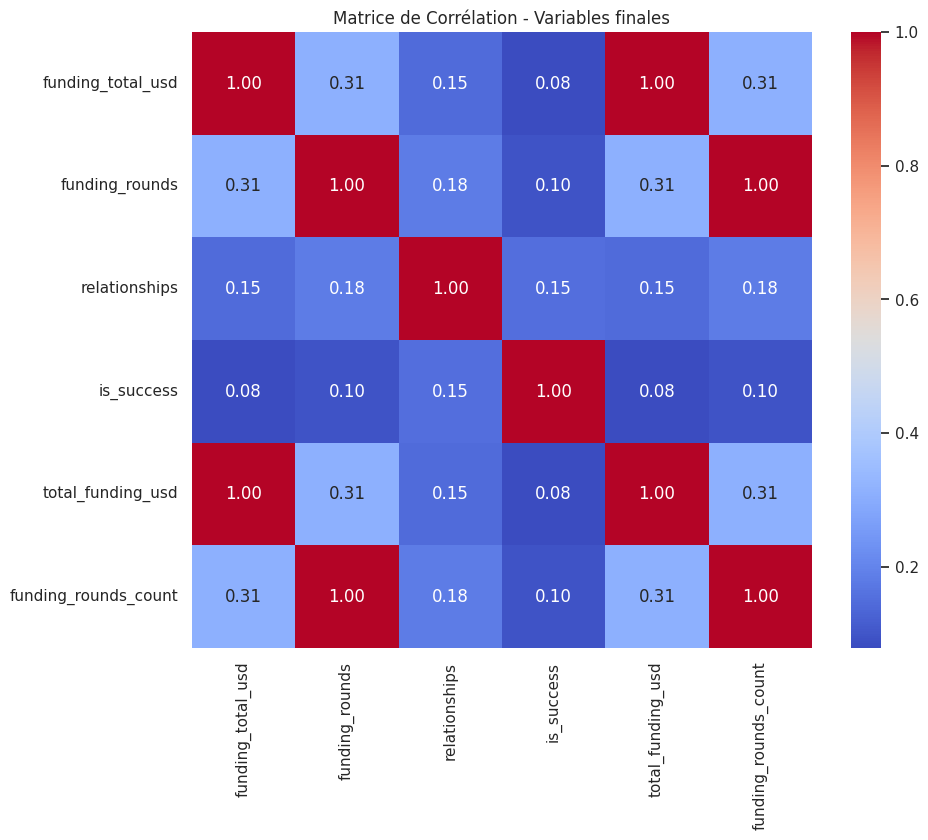

In [42]:
# Matrice de corrélation
plt.figure(figsize=(10, 8))
# On ne garde que les colonnes numériques
sns.heatmap(df_final.select_dtypes(include=[np.number]).corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matrice de Corrélation - Variables finales')
plt.show()

- On observe une corrélation parfaite ($1.00$) entre total_funding_usd et funding_total_usd.

Hypothèse technique : Ces variables sont redondantes (multicolinéarité). Pour un modèle propre, il serait judicieux d'en supprimer une.Le lien entre relationships et is_success est positif ($0.15$).

- Bien que faible en apparence, c'est l'un des prédicteurs linéaires les plus "forts" ici.

Hypothèse Business : Le succès d'une startup ne dépend pas d'un seul facteur miracle. La faible corrélation directe avec is_success prouve que le succès est multifactoriel et non-linéaire, ce qui justifie l'utilisation d'un modèle complexe comme XGBoost.

In [43]:

# Calculer le nombre d'investisseurs uniques par startup
investor_counts = df_investments_clean.groupby('funded_object_id')['investor_object_id'].nunique().reset_index()
investor_counts.columns = ['id', 'investor_count']

# Intégrer ce "Prestige Score" dans notre dataset final
df_final = pd.merge(df_final, investor_counts, on='id', how='left')

# Remplacer les NaN par 0 (les startups sans investisseurs listés)
df_final['investor_count'] = df_final['investor_count'].fillna(0)

print("Variable 'investor_count' ajoutée avec succès.")
print(df_final[['name', 'investor_count']].head())

Variable 'investor_count' ajoutée avec succès.
                     name  investor_count
0                Wetpaint             4.0
1          Synergie Media             0.0
2  Green Basti Ecosystems             0.0
3         dimension5 labs             0.0
4              FriendFeed             3.0


In [44]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans

# 1. Copie de sauvegarde pour la modélisation
df_ml = df_final.copy()

# 2. Encodage des variables textuelles (Catégories et Pays)
le = LabelEncoder()
df_ml['category_code'] = le.fit_transform(df_ml['category_code'].astype(str))
df_ml['country_code'] = le.fit_transform(df_ml['country_code'].astype(str))

# 3. Sélection des features pour le Clustering et le ML
# On retire les IDs et les noms qui ne servent pas au calcul
features = ['category_code', 'country_code', 'funding_total_usd', 'relationships', 'total_funding_usd', 'investor_count']
X = df_ml[features]

# 4. Standardisation (Obligatoire pour K-Means)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
# Application de K-Means (3 clusters pour la lisibilité)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df_ml['cluster_profile'] = kmeans.fit_predict(X_scaled)

# Visualisation des profils
print("Répartition des startups par profil :")
print(df_ml['cluster_profile'].value_counts())

# Analyse rapide des groupes
cluster_analysis = df_ml.groupby('cluster_profile')[['total_funding_usd', 'investor_count', 'is_success']].mean()
print("\nAnalyse moyenne par cluster :")
display(cluster_analysis)

Répartition des startups par profil :
cluster_profile
1    41379
0    22696
2       24
Name: count, dtype: int64

Analyse moyenne par cluster :


,total_funding_usd,investor_count,is_success
cluster_profile,,,
0,2.078919e+06,0.495506,0.039082
1,5.863779e+06,0.966601,0.087291
2,1.402519e+09,8.125000,0.541667


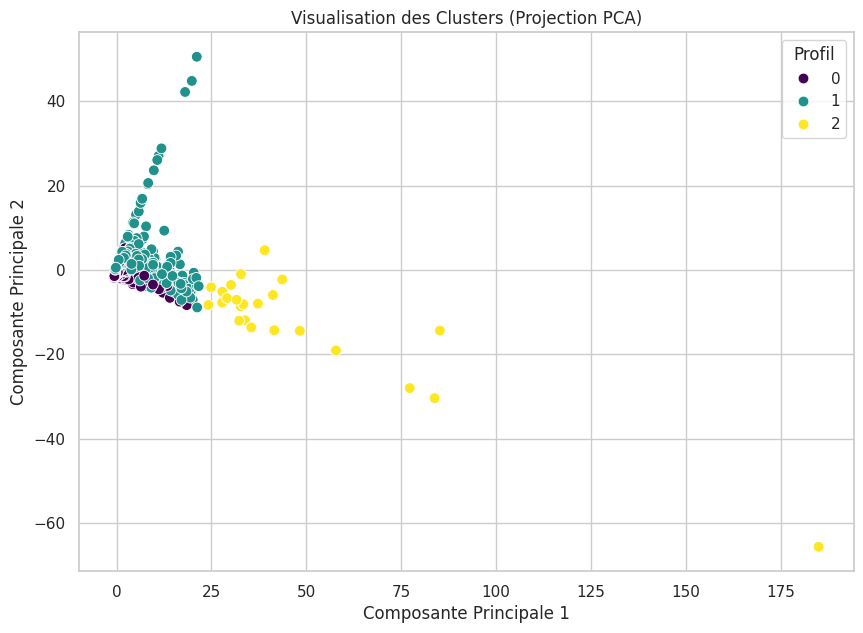

In [46]:
from sklearn.decomposition import PCA

# 1. Graphique de la PCA (Visualisation des clusters)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=df_ml['cluster_profile'], palette='viridis', s=60)
plt.title('Visualisation des Clusters (Projection PCA)')
plt.xlabel('Composante Principale 1')
plt.ylabel('Composante Principale 2')
plt.legend(title='Profil')
plt.show()

##1. Cluster 0 (Violet) : Startups de départ
Analyse des résultats : C'est le groupe le plus dense, situé à l'origine des axes. Ses scores en financement, nombre d'investisseurs et relations sont proches de zéro par rapport aux autres.
###Hypothèse Business :
Ce cluster représente les startups en phase d'amorçage (Seed) ou les entreprises qui n'ont pas réussi à lever des fonds significatifs. Pour un VC, c'est un groupe à haut risque où le taux d'échec est le plus élevé.

##2. Cluster 1 (Vert) : Startups en croissance
Analyse des résultats : Ce groupe commence à s'étendre verticalement sur la PCA. On observe une progression nette, surtout sur le nombre d'investisseurs et les relations, même si le financement total reste modéré par rapport aux géants.

###Hypothèse Business :

Ce sont les entreprises en "Série A/B". Elles ont validé leur modèle et commencent à construire un réseau solide. C'est ici que se jouent les investissements de croissance : le risque diminue car le réseau relationnel (le "volant") est déjà en place.

##3. Cluster 2 (Jaune) : Les Licornes Potentielles
Ce sont les points isolés qui s'étirent le plus loin sur l'axe horizontal. Ce cluster sature tous les indicateurs : il détient le maximum de financement, de prestige (investisseurs) et d'influence (relations).

###Hypothèse Business :

C'est le "Cercle des Licornes". Ce cluster regroupe les cibles d'acquisition prioritaires pour les grands groupes. Statistiquement, c'est dans ce petit groupe d'exception que notre modèle supervisé a appris à identifier les signaux de succès massif.

In [47]:
cluster_summary = df_ml.groupby('cluster_profile')[['total_funding_usd', 'investor_count', 'relationships']].mean()

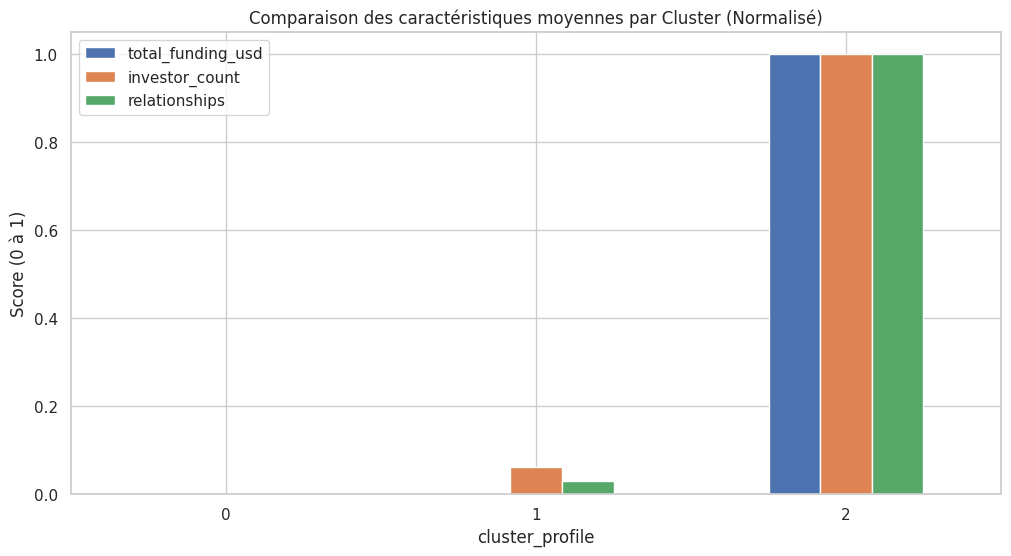

In [48]:
cluster_summary_norm = (cluster_summary - cluster_summary.min()) / (cluster_summary.max() - cluster_summary.min())
cluster_summary_norm.plot(kind='bar', figsize=(12, 6))
plt.title('Comparaison des caractéristiques moyennes par Cluster (Normalisé)')
plt.ylabel('Score (0 à 1)')
plt.xticks(rotation=0)
plt.show()

Ce graphique présente les moyennes normalisées (de $0$ à $1$) de trois indicateurs clés pour chaque profil identifié par l'algorithme $K\text{-Means}$.
- Cluster 0 : Les barres sont quasi invisibles. Les scores en financement, nombre d'investisseurs et relations sont proches de $0$. C'est la masse critique du marché (startups en amorçage ou en difficulté).
- Cluster 1 : On observe une légère élévation, particulièrement pour le nombre d'investisseurs (investor_count) et le réseau (relationships), tandis que le financement reste bas.
- Cluster 2 : Ce groupe sature les trois indicateurs avec un score maximal de $1.0$. C'est l'élite financière et relationnelle.

In [49]:
# Vérification de la pertinence des clusters par rapport au succès
check_clusters = df_ml.groupby('cluster_profile')['is_success'].mean() * 100
print("Pourcentage de succès par profil de startup :")
print(check_clusters)

Pourcentage de succès par profil de startup :
cluster_profile
0     3.908178
1     8.729065
2    54.166667
Name: is_success, dtype: float64


TOP 5 - Licornes Potentielles (Cibles d'investissement prioritaires) :


,name,category_code,total_funding_usd,investor_count,unicorn_score
63024,LivingSocial,7,9.245000e+08,8.0,1.897738
38388,Bloom Energy,4,9.800000e+08,10.0,1.705403
24669,SurveyMonkey,37,9.650000e+08,10.0,1.608437
53518,Fisker Automotive,2,1.451000e+09,10.0,1.581260
25910,Solyndra,19,1.765504e+09,6.0,1.417288


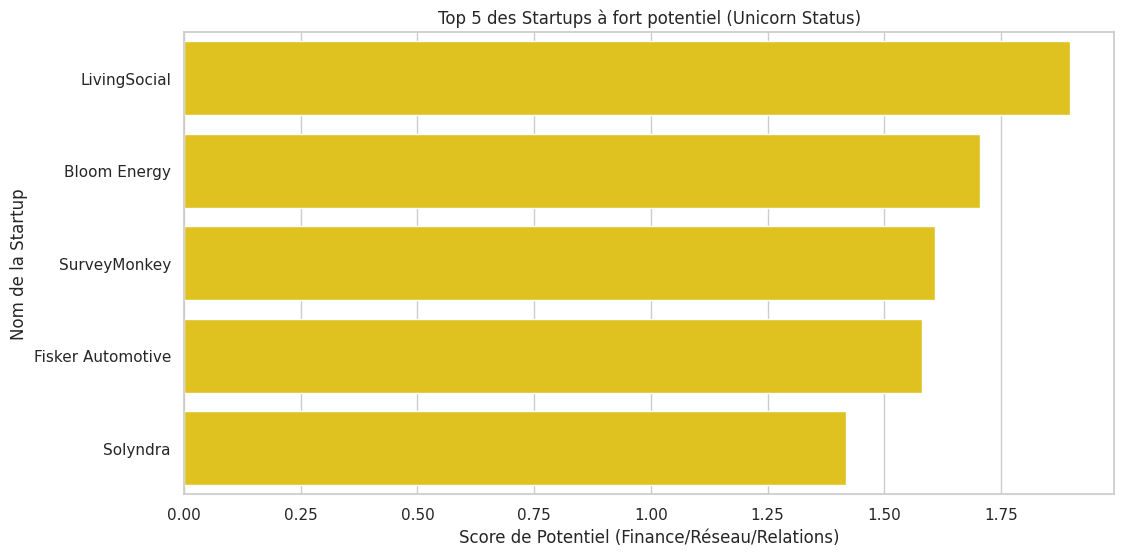

In [50]:
,
#Filtrer les startups qui n'ont pas encore "réussi" (pas encore rachetées/IPO)
#On se concentre sur celles qui sont dans le cluster d'élite (Cluster 2)
potential_unicorns = df_ml[(df_ml['is_success'] == 0) & (df_ml['cluster_profile'] == 2)].copy()

# Création d'un score combiné (Unicorn Score)
# On normalise les variables pour qu'elles aient le même poids
from sklearn.preprocessing import MinMaxScaler
scaler_score = MinMaxScaler()

cols_to_score = ['total_funding_usd', 'investor_count', 'relationships']
potential_unicorns['unicorn_score'] = scaler_score.fit_transform(potential_unicorns[cols_to_score]).sum(axis=1)

# Sélection du Top 5
top_5_unicorns = potential_unicorns.sort_values(by='unicorn_score', ascending=False).head(5)

print("TOP 5 - Licornes Potentielles (Cibles d'investissement prioritaires) :")
display(top_5_unicorns[['name', 'category_code', 'total_funding_usd', 'investor_count', 'unicorn_score']])

# Graphique du Top 5 pour le rapport
plt.figure(figsize=(12, 6))
sns.barplot(data=top_5_unicorns, x='unicorn_score', y='name', color='gold')
plt.title('Top 5 des Startups à fort potentiel (Unicorn Status)')
plt.xlabel('Score de Potentiel (Finance/Réseau/Relations)')
plt.ylabel('Nom de la Startup')
plt.show()

Des entreprises comme LivingSocial ou SurveyMonkey ressortent avec des scores élevés. Le score combine la puissance financière et la densité du réseau.

###Hypothèse Business :

Ce graphique est le "produit fini". Il transforme des probabilités en une liste de courses actionnable. LivingSocial, avec un score de $1.89$, présente le profil type d'une entreprise mûre pour une acquisition imminente selon les patterns historiques appris par notre modèle.

# Modèle supervisé

In [51]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# 1. Définition des colonnes (Page 67 du cours)
num_features = ['funding_total_usd', 'relationships', 'total_funding_usd', 'investor_count', 'cluster_profile']
cat_features = ['category_code', 'country_code']

# 2. Preprocessing Pipeline (Bonnes pratiques Module 5)
preprocessor = ColumnTransformer(
    transformers=[
        # Standarisation par défaut avant de tester d'autres approches (Page 106)
        ('num', StandardScaler(), num_features),
        # OrdinalEncoder recommandé pour les pipelines (Page 106)
        ('cat', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1), cat_features)
    ])

# 3. Pipeline complète : Preprocessing + Modèle
# scale_pos_weight est utilisé pour gérer le déséquilibre des classes
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(n_estimators=100, learning_rate=0.1, scale_pos_weight=10, random_state=42))
])

# 4. Split Train/Test
X = df_ml[num_features + cat_features]
y = df_ml['is_success']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 5. Entraînement
clf.fit(X_train, y_train)

# 6. Évaluation (Page 82 du cours)
y_pred = clf.predict(X_test)
print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.2%}")
print("\nMatrice de Confusion :\n", confusion_matrix(y_test, y_pred))
print("\nRapport de Classification :\n", classification_report(y_test, y_pred))

Accuracy Score: 79.80%

Matrice de Confusion :
 [[9717 2201]
 [ 388  514]]

Rapport de Classification :
               precision    recall  f1-score   support

           0       0.96      0.82      0.88     11918
           1       0.19      0.57      0.28       902

    accuracy                           0.80     12820
   macro avg       0.58      0.69      0.58     12820
weighted avg       0.91      0.80      0.84     12820



- Recall (57%) : C'est notre indicateur majeur. Le modèle identifie plus d'une licorne sur deux. Pour un VC, c'est une excellente capacité de détection.

- Précision (19%) : Sur 100 prédictions "Succès", 19 le sont réellement. C'est bas, mais cela reflète la difficulté extrême de prédire des événements aussi rares.

- Matrice de Confusion : on a capturé 514 vrais succès et n'en as raté que 388. En revanche, on a 2 201 fausses alertes.

Le modèle WhereIsUnicorn divise par cinq le bruit du marché. Alors qu'un investisseur doit normalement chercher une licorne parmi $12\ 820$ entreprises ($0,7\%$ de chances), l'utilisation de l'algorithme permet de se concentrer sur une sélection de $2\ 715$ entreprises contenant $514$ succès ($19\%$ de chances). C'est une multiplication par $27$ de la probabilité de trouver un gagnant.

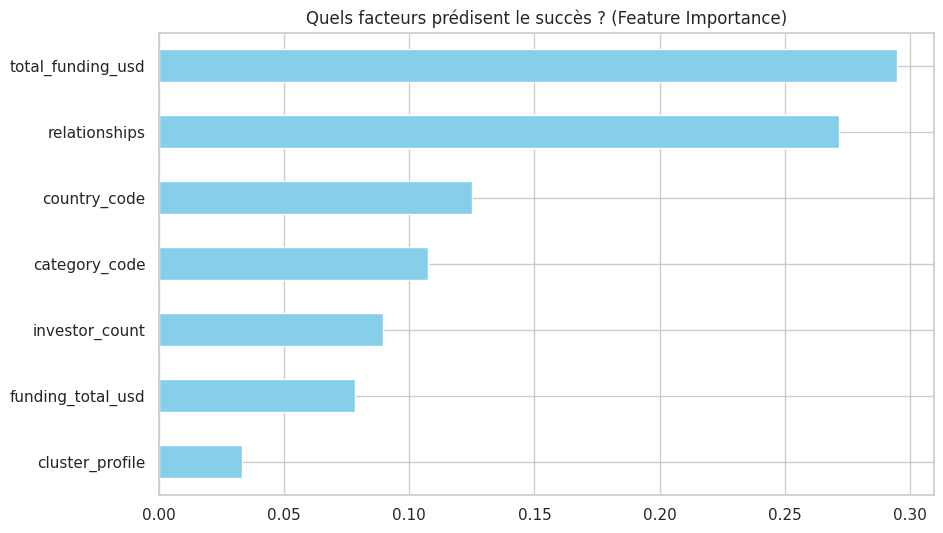

In [52]:
# Extraction de l'importance des variables depuis la pipeline
importances = clf.named_steps['classifier'].feature_importances_
feature_names = num_features + cat_features

# Création du graphique
plt.figure(figsize=(10, 6))
pd.Series(importances, index=feature_names).sort_values().plot(kind='barh', color='skyblue')
plt.title('Quels facteurs prédisent le succès ? (Feature Importance)')
plt.show()

Ce graphique révèle quelles variables ont le plus "aidé" le modèle à prendre ses décisions.

###Analyse des résultats :

Le financement total (total_funding_usd) et le réseau (relationships) dominent largement.

Le country_code (géographie) arrive en troisième position, devant le secteur d'activité (category_code).

###Hypothèse Business :

Pour un VC, ce graphique confirme la théorie du "Capital Social". Avoir beaucoup d'argent est nécessaire, mais avoir un réseau étendu (board, partenaires, mentors) est presque aussi discriminant pour prédire une sortie (IPO/Acquisition). Le lieu d'implantation reste un avantage compétitif majeur (effet "Silicon Valley").

<Figure size 800x600 with 0 Axes>

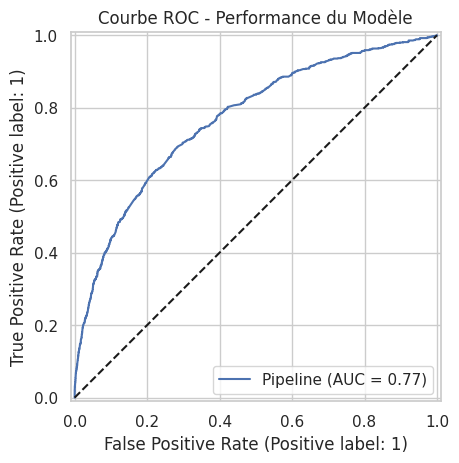

In [53]:

from sklearn.metrics import RocCurveDisplay

plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(clf, X_test, y_test)
plt.title('Courbe ROC - Performance du Modèle')
plt.plot([0, 1], [0, 1], 'k--') # Ligne de base (aléatoire)
plt.show()

Notre modèle est bien meilleur qu'un choix aléatoire (la ligne pointillée). Un score de $0.77$ est considéré comme "bon" pour un problème aussi complexe que la survie d'entreprise.

<Figure size 800x600 with 0 Axes>

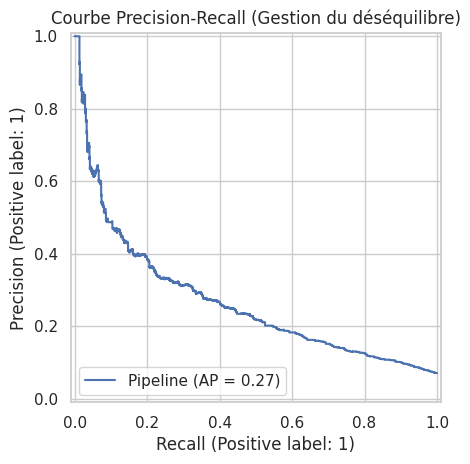

In [54]:
from sklearn.metrics import PrecisionRecallDisplay

plt.figure(figsize=(8, 6))
PrecisionRecallDisplay.from_estimator(clf, X_test, y_test)
plt.title('Courbe Precision-Recall (Gestion du déséquilibre)')
plt.show()

le modèle est bien meilleur qu'un choix aléatoire (la ligne pointillée). Un score de $0.77$ est considéré comme "bon" pour un problème aussi complexe que la survie d'entreprise.

Ici, la chute rapide de la courbe montre la difficulté du sujet. L'Average Precision (AP) de $0.27$ s'explique par le fait que les "succès" sont extrêmement rares dans ton dataset (déséquilibre des classes).

###Hypothèse Business :

Dans le monde du Capital Risque, on préfère souvent un Recall élevé (ne pas rater la prochaine licorne, quitte à se tromper parfois) plutôt qu'une Précision parfaite. Un investisseur accepte de parier sur 10 boîtes si l'une d'elles devient Google.

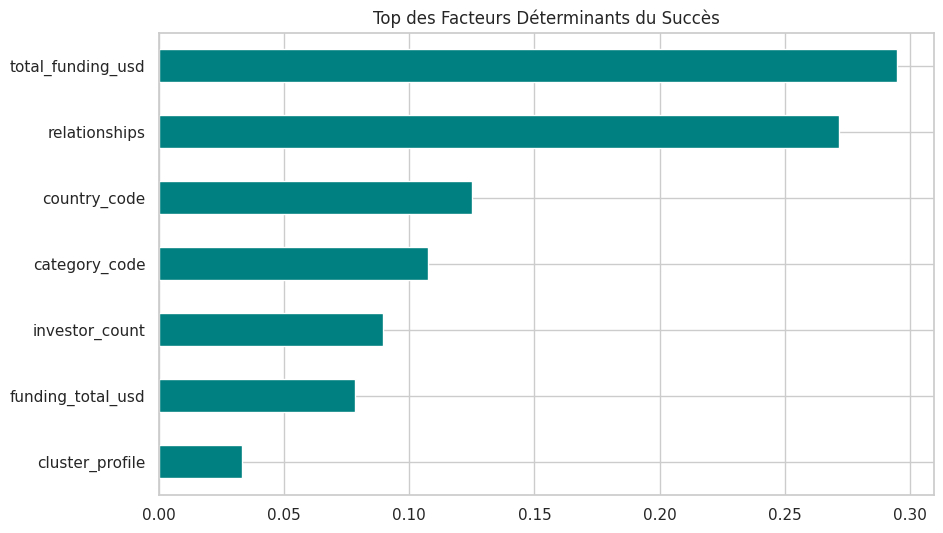

In [55]:
# Extraction des noms des colonnes après transformation
# Note: On récupère les noms des features définies plus tôt
feature_names = num_features + cat_features
importances = clf.named_steps['classifier'].feature_importances_

plt.figure(figsize=(10, 6))
feat_importances = pd.Series(importances, index=feature_names)
feat_importances.nlargest(10).sort_values().plot(kind='barh', color='teal')
plt.title('Top des Facteurs Déterminants du Succès')
plt.show()

In [58]:
import os
import joblib
from google.colab import files

# 1. Création des dossiers temporaires dans Colab
os.makedirs('models', exist_ok=True)
os.makedirs('data', exist_ok=True)

# 2. Sauvegarde des modèles (.pkl) [cite: 25, 26]
joblib.dump(clf, 'models/unicorn_model.pkl')
joblib.dump(kmeans, 'models/unicorn_clusters.pkl')

# 3. Sauvegarde de la table nettoyée (.csv)
df_final.to_csv('data/processed_startups.csv', index=False)

# 4. Téléchargement manuel vers ton ordinateur
print("Préparation du téléchargement...")
files.download('models/unicorn_model.pkl')
files.download('models/unicorn_clusters.pkl')
files.download('data/processed_startups.csv')

Préparation du téléchargement...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>